# Optimization Debugging - Spatial FDR

**Goal:** Diagnose why optimizer isn't moving (gradient = 1e11, α stays at 0)

**Test scenario:**
- 2D square spatial domain [0,1] × [0,1]
- Top-right quarter: 90% alternatives (α should ≈ 0.1)
- Other three quarters: 90% nulls (α should ≈ 0.9)
- Clear spatial structure for kernel to learn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import cdist
import sys
sys.path.insert(0, '/mnt/user-data/outputs')

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

np.random.seed(42)

## 1. Generate Toy Data with Clear Spatial Structure

In [2]:
# Parameters
n_samples = 200  # Keep small for debugging
effect_size = 2.0

# Sample locations uniformly in [0,1] × [0,1]
locations = np.random.rand(n_samples, 2)

# Top-right quarter: [0.5,1] × [0.5,1]
in_top_right = (locations[:, 0] > 0.5) & (locations[:, 1] > 0.5)

# Generate labels
labels = np.zeros(n_samples)

# Top-right: 90% alternatives
top_right_indices = np.where(in_top_right)[0]
n_alt_topright = int(0.9 * len(top_right_indices))
labels[top_right_indices[:n_alt_topright]] = 1

# Other three quarters: 10% alternatives (90% nulls)
other_indices = np.where(~in_top_right)[0]
n_alt_other = int(0.1 * len(other_indices))
labels[other_indices[:n_alt_other]] = 1

# Generate z-scores
z_scores = np.random.randn(n_samples)
z_scores[labels == 1] += effect_size

# Convert to p-values
p_values = 1 - stats.norm.cdf(z_scores)

# Summary
print("DATA SUMMARY")
print("="*70)
print(f"Total samples: {n_samples}")
print(f"Top-right quarter: {len(top_right_indices)} points")
print(f"  Alternatives: {np.sum(labels[in_top_right])}/{len(top_right_indices)} ({np.mean(labels[in_top_right]):.1%})")
print(f"Other quarters: {len(other_indices)} points")
print(f"  Alternatives: {np.sum(labels[~in_top_right])}/{len(other_indices)} ({np.mean(labels[~in_top_right]):.1%})")
print(f"\nOverall:")
print(f"  Alternatives: {np.sum(labels)}/{n_samples} ({np.mean(labels):.1%})")
print(f"  True π₀: {1 - np.mean(labels):.3f}")
print(f"\nExpected α:")
print(f"  Top-right: ≈0.1 (10% nulls)")
print(f"  Elsewhere: ≈0.9 (90% nulls)")

DATA SUMMARY
Total samples: 200
Top-right quarter: 54 points
  Alternatives: 48.0/54 (88.9%)
Other quarters: 146 points
  Alternatives: 14.0/146 (9.6%)

Overall:
  Alternatives: 62.0/200 (31.0%)
  True π₀: 0.690

Expected α:
  Top-right: ≈0.1 (10% nulls)
  Elsewhere: ≈0.9 (90% nulls)


## 2. Visualize Data

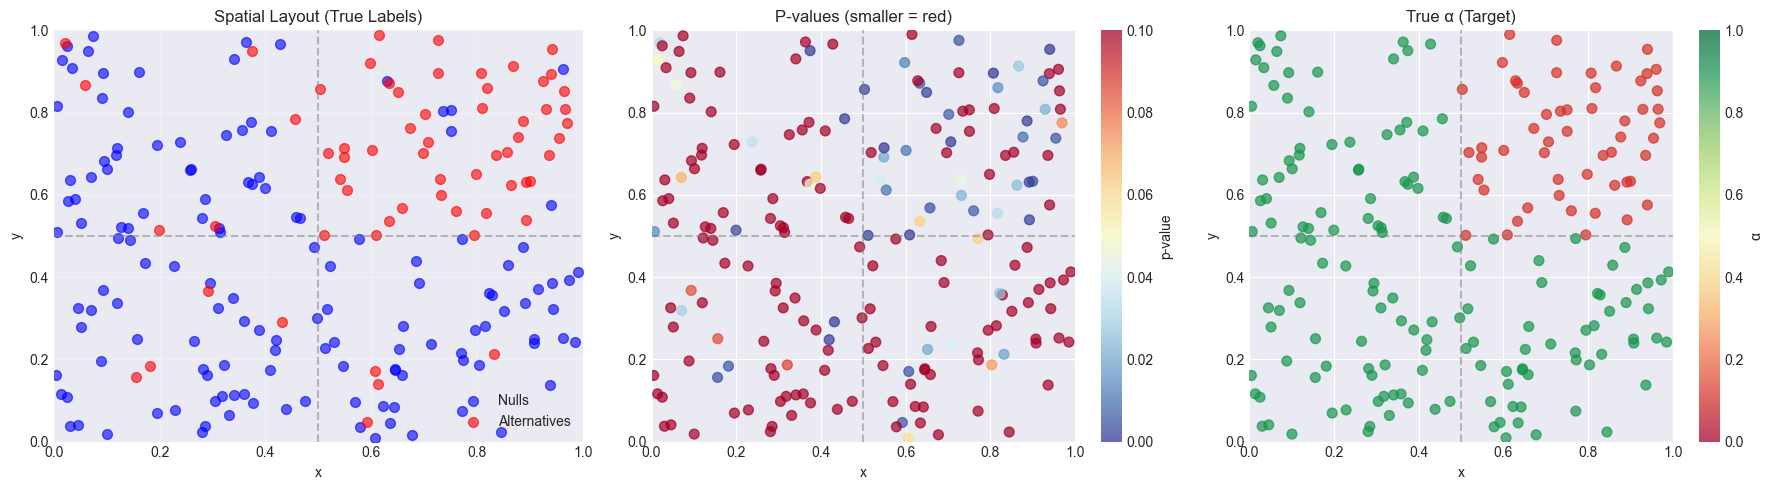

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Spatial locations colored by label
ax = axes[0]
nulls = labels == 0
alts = labels == 1
ax.scatter(locations[nulls, 0], locations[nulls, 1], c='blue', alpha=0.6, s=50, label='Nulls')
ax.scatter(locations[alts, 0], locations[alts, 1], c='red', alpha=0.6, s=50, label='Alternatives')
ax.axvline(0.5, color='gray', linestyle='--', alpha=0.5)
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Spatial Layout (True Labels)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Plot 2: P-values
ax = axes[1]
scatter = ax.scatter(locations[:, 0], locations[:, 1], c=p_values, 
                     cmap='RdYlBu_r', s=50, alpha=0.7, vmin=0, vmax=0.1)
ax.axvline(0.5, color='gray', linestyle='--', alpha=0.5)
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('P-values (smaller = red)')
plt.colorbar(scatter, ax=ax, label='p-value')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Plot 3: True α (what we want to learn)
ax = axes[2]
true_alpha = np.ones(n_samples)
true_alpha[in_top_right] = 0.1  # Top-right: 10% nulls
true_alpha[~in_top_right] = 0.9  # Elsewhere: 90% nulls
scatter = ax.scatter(locations[:, 0], locations[:, 1], c=true_alpha,
                     cmap='RdYlGn', s=50, alpha=0.7, vmin=0, vmax=1)
ax.axvline(0.5, color='gray', linestyle='--', alpha=0.5)
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('True α (Target)')
plt.colorbar(scatter, ax=ax, label='α')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 3. Estimate f₀ and f₁

In [4]:
# Use theoretical null (f0 = 1)
def f0(p):
    return np.ones_like(np.atleast_1d(p))

# Fit f1 to small p-values
p_small = p_values[p_values < 0.1]

if len(p_small) >= 10:
    from scipy.optimize import minimize
    
    def neg_log_lik(params):
        a, b = params
        if a <= 0 or b <= 0:
            return 1e10
        return -np.sum(stats.beta.logpdf(p_small, a, b))
    
    result = minimize(neg_log_lik, x0=[0.5, 5.0], method='L-BFGS-B',
                     bounds=[(0.1, 2.0), (1.0, 20.0)])
    
    if result.success:
        a_fit, b_fit = result.x
        def f1(p):
            p_arr = np.atleast_1d(p)
            p_safe = np.clip(p_arr, 1e-10, 1-1e-10)
            return stats.beta.pdf(p_safe, a_fit, b_fit)
        print(f"f₁ fitted: Beta({a_fit:.2f}, {b_fit:.2f})")
    else:
        def f1(p):
            return 10 * np.exp(-10 * np.atleast_1d(p))
        print("f₁ using fallback: exponential")
else:
    def f1(p):
        return 10 * np.exp(-10 * np.atleast_1d(p))
    print("f₁ using fallback: exponential")

# Estimate π₀
pi0 = np.clip(np.mean(p_values > 0.5) / 0.5, 0.1, 1.0)
print(f"π₀ estimated: {pi0:.3f}")

# Evaluate
f0_vals = f0(p_values)
f1_vals = f1(p_values)

print(f"\nf₀ at p-values: min={f0_vals.min():.3f}, max={f0_vals.max():.3f}")
print(f"f₁ at p-values: min={f1_vals.min():.3f}, max={f1_vals.max():.3f}")

f₁ fitted: Beta(0.51, 20.00)
π₀ estimated: 0.810

f₀ at p-values: min=1.000, max=1.000
f₁ at p-values: min=0.000, max=597.248


## 4. Spatially Sort Points and Compute Kernel

**Important:** We sort points spatially so the kernel matrix shows structure!

In [5]:
# Sort points spatially (lexicographic: x first, then y)
sort_indices = np.lexsort((locations[:, 1], locations[:, 0]))
locations_sorted = locations[sort_indices]
p_values_sorted = p_values[sort_indices]
labels_sorted = labels[sort_indices]
in_top_right_sorted = in_top_right[sort_indices]
f0_vals_sorted = f0(p_values_sorted)
f1_vals_sorted = f1(p_values_sorted)

print("SPATIAL SORTING")
print("="*70)
print(f"Original order: point 0 at {locations[0]}")
print(f"Sorted order: point 0 at {locations_sorted[0]}")

# Use sorted locations for everything below
locations = locations_sorted
p_values = p_values_sorted
labels = labels_sorted
in_top_right = in_top_right_sorted
f0_vals = f0_vals_sorted
f1_vals = f1_vals_sorted

SPATIAL SORTING
Original order: point 0 at [0.37454012 0.95071431]
Sorted order: point 0 at [0.00506158 0.16080805]


In [6]:
# Matérn kernel
def matern_kernel(X1, X2, length_scale=0.2, nu=2.5):
    from scipy.special import kv, gamma
    dists = cdist(X1, X2, metric='euclidean')
    if nu == 2.5:
        tmp = np.sqrt(5) * dists / length_scale
        K = (1 + tmp + tmp**2 / 3) * np.exp(-tmp)
    else:
        K = np.exp(-dists**2 / (2 * length_scale**2))
    return K

# Compute kernel
length_scale = 0.2
K = matern_kernel(locations, locations, length_scale=length_scale, nu=2.5)

print(f"\nKernel matrix: {K.shape}")
print(f"  Condition number: {np.linalg.cond(K):.2e}")


Kernel matrix: (200, 200)
  Condition number: 1.41e+07


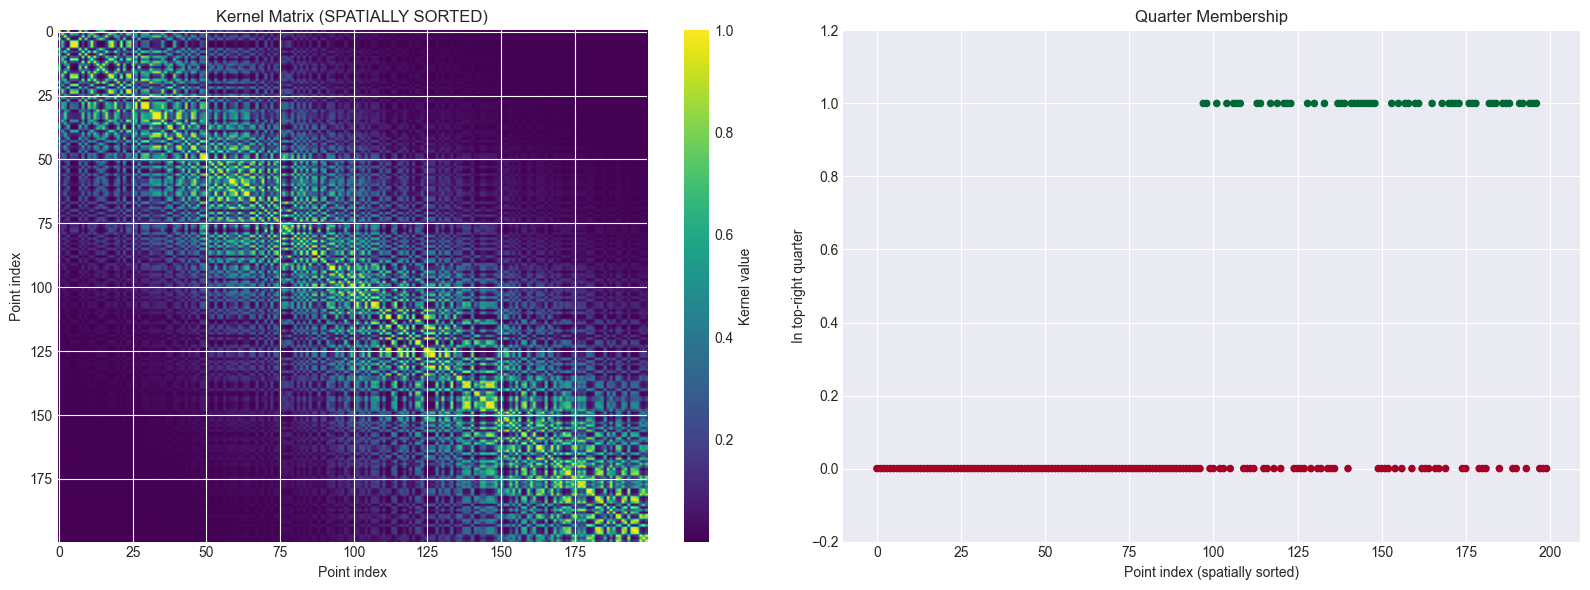


Note: Kernel shows SMOOTH spatial structure, not discrete quarters!


In [7]:
# Visualize kernel
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Kernel matrix
ax = axes[0]
im = ax.imshow(K, cmap='viridis', aspect='auto')
plt.colorbar(im, ax=ax, label='Kernel value')
ax.set_title(f'Kernel Matrix (SPATIALLY SORTED)')
ax.set_xlabel('Point index')
ax.set_ylabel('Point index')

# Right: Show which quarter each point belongs to
ax = axes[1]
quarter_map = in_top_right.astype(int)
ax.scatter(np.arange(n_samples), quarter_map, c=quarter_map, cmap='RdYlGn', s=20)
ax.set_xlabel('Point index (spatially sorted)')
ax.set_ylabel('In top-right quarter')
ax.set_title('Quarter Membership')
ax.set_ylim(-0.2, 1.2)

plt.tight_layout()
plt.show()

print("\nNote: Kernel shows SMOOTH spatial structure, not discrete quarters!")

## 5. Manual Optimization with Full Diagnostics

In [8]:
# Optimization parameters
lambda_reg = 0.004
lambda_bound = 10**2
learning_rate = 0.01
max_grad_norm = 10.0 
max_iter = 15000

# Initialize
c = np.zeros(n_samples)

# Storage
history = {
    'loss': [], 'data_loss': [], 'rkhs_penalty': [], 'bound_penalty': [],
    'grad_norm': [], 'alpha_min': [], 'alpha_max': [], 'alpha_mean': [],
    'n_violations': []
}

print("OPTIMIZATION")
print("="*70)

for iteration in range(max_iter):
    # Forward pass
    alpha = K @ c
    mixture = alpha * f0_vals + (1 - alpha) * f1_vals
    mixture = np.clip(mixture, 1e-10, None)
    
    # Losses
    data_loss = -np.sum(np.log(mixture))
    rkhs_penalty = lambda_reg * (c @ K @ c)
    violations_lower = np.maximum(0, -alpha)
    violations_upper = np.maximum(0, alpha - 1)
    bound_penalty = lambda_bound * np.sum(violations_lower**2 + violations_upper**2)
    loss = data_loss + rkhs_penalty + bound_penalty
    
    # Natural gradient
    grad_alpha = -(f0_vals - f1_vals) / mixture
    grad_bound = 2 * lambda_bound * (-violations_lower + violations_upper)
    grad_nat = grad_alpha + grad_bound + 2 * lambda_reg * c
    
    # After computing grad_nat:
    grad_norm = np.linalg.norm(grad_nat)
    
    if grad_norm > max_grad_norm:
        grad_nat = grad_nat * (max_grad_norm / grad_norm)
    
    c = c - learning_rate * grad_nat
    
    # Store
    history['loss'].append(loss)
    history['data_loss'].append(data_loss)
    history['rkhs_penalty'].append(rkhs_penalty)
    history['bound_penalty'].append(bound_penalty)
    history['grad_norm'].append(np.linalg.norm(grad_nat))
    history['alpha_min'].append(alpha.min())
    history['alpha_max'].append(alpha.max())
    history['alpha_mean'].append(alpha.mean())
    history['n_violations'].append(np.sum((alpha < 0) | (alpha > 1)))
    
    if iteration % 50 == 0 or iteration < 10:
        print(f"Iter {iteration:3d}: loss={loss:10.3f}, |∇|={np.linalg.norm(grad_nat):.2e}, "
              f"α=[{alpha.min():.3f}, {alpha.max():.3f}]")

alpha_final = K @ c
print(f"\nFINAL: α ∈ [{alpha_final.min():.3f}, {alpha_final.max():.3f}]")
print(f"Top-right: {alpha_final[in_top_right].mean():.3f} (expected ≈0.1)")
print(f"Elsewhere: {alpha_final[~in_top_right].mean():.3f} (expected ≈0.9)")

OPTIMIZATION
Iter   0: loss=  1773.953, |∇|=1.00e+01, α=[0.000, 0.000]
Iter   1: loss=    95.439, |∇|=1.00e+01, α=[0.019, 0.197]
Iter   2: loss=     4.118, |∇|=1.00e+01, α=[0.134, 0.358]
Iter   3: loss=   -43.803, |∇|=1.00e+01, α=[0.184, 0.564]
Iter   4: loss=   -68.056, |∇|=1.00e+01, α=[0.221, 0.735]
Iter   5: loss=   -80.344, |∇|=1.00e+01, α=[0.244, 0.858]
Iter   6: loss=   -86.105, |∇|=1.00e+01, α=[0.255, 0.931]
Iter   7: loss=   -89.017, |∇|=1.00e+01, α=[0.262, 0.960]
Iter   8: loss=   -90.990, |∇|=1.00e+01, α=[0.266, 0.971]
Iter   9: loss=   -92.525, |∇|=1.00e+01, α=[0.270, 0.980]
Iter  50: loss=  -106.608, |∇|=1.00e+01, α=[0.140, 1.044]
Iter 100: loss=  -111.181, |∇|=1.00e+01, α=[-0.006, 1.027]
Iter 150: loss=  -114.185, |∇|=1.00e+01, α=[0.012, 1.023]
Iter 200: loss=  -117.191, |∇|=1.00e+01, α=[-0.018, 1.027]
Iter 250: loss=  -115.012, |∇|=1.00e+01, α=[-0.027, 1.010]
Iter 300: loss=  -117.036, |∇|=1.00e+01, α=[-0.005, 1.062]
Iter 350: loss=  -120.915, |∇|=1.00e+01, α=[0.010, 1.03

## 6. Diagnostic Plots

/tmp/ipykernel_605094/2900385512.py:5: RuntimeWarning: invalid value encountered in log
  axes[0,0].plot(iters, np.log(history['loss']), 'b-', linewidth=2)


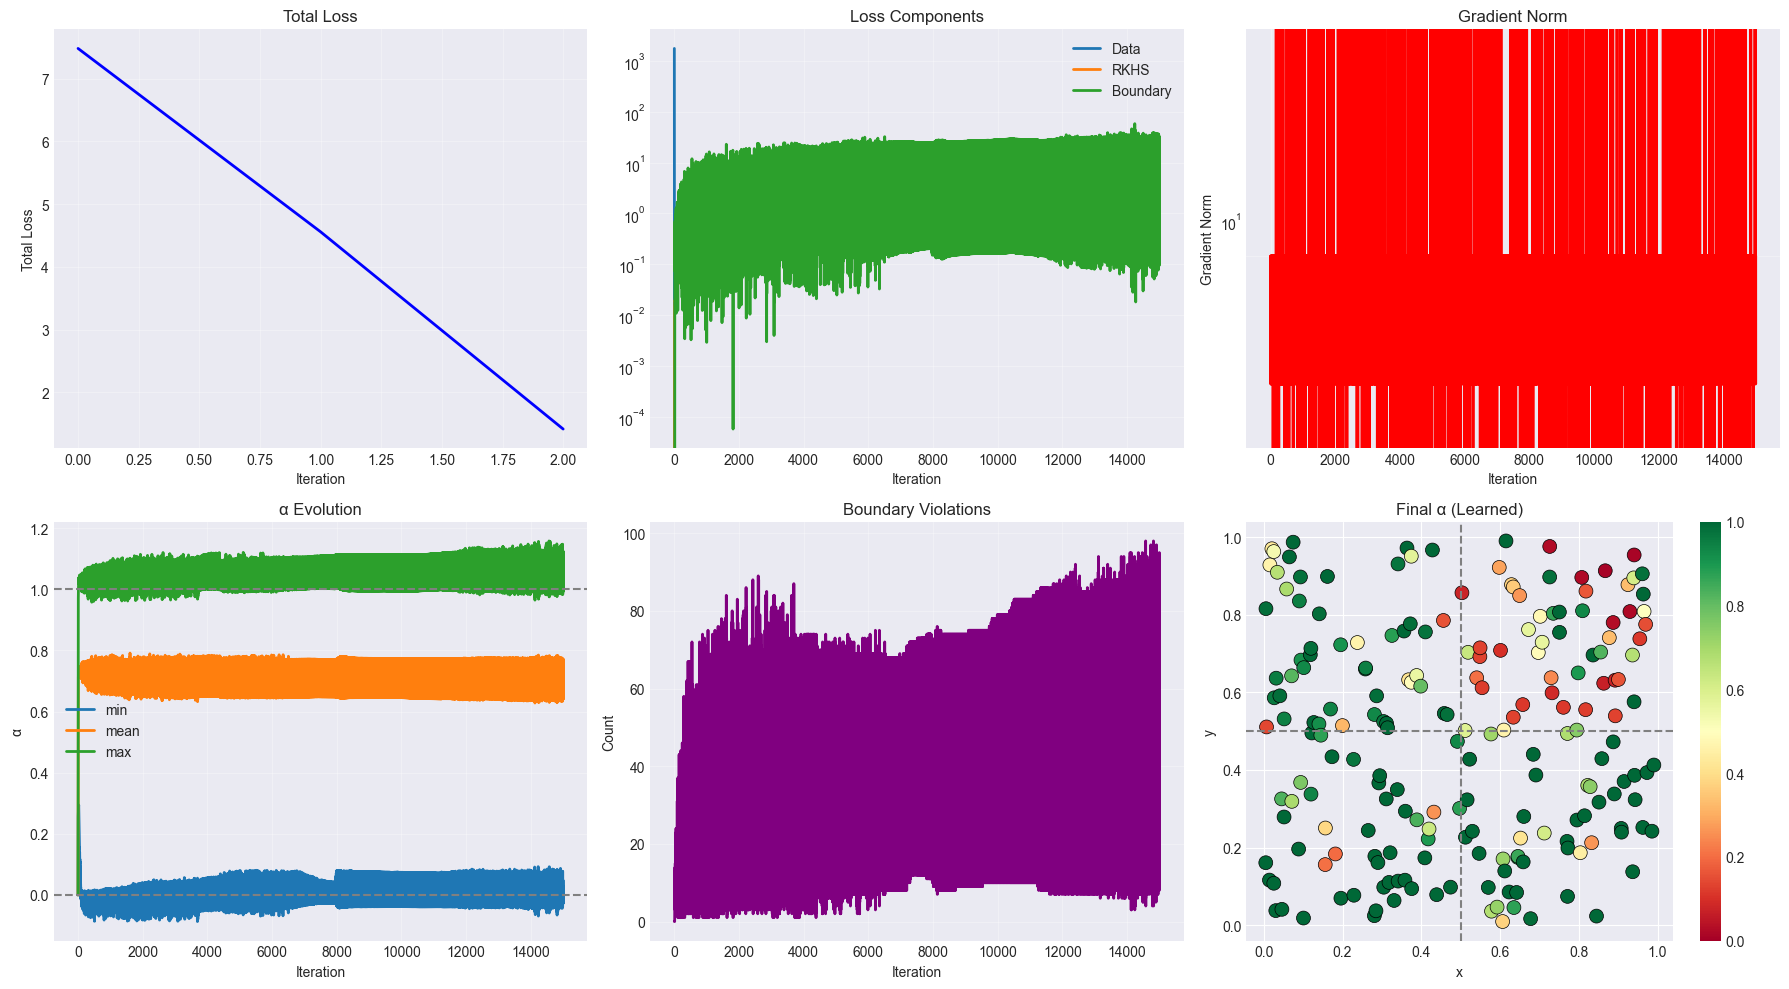

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
iters = np.arange(len(history['loss']))

# Loss
axes[0,0].plot(iters, np.log(history['loss']), 'b-', linewidth=2)
axes[0,0].set_xlabel('Iteration')
axes[0,0].set_ylabel('Total Loss')
axes[0,0].set_title('Total Loss')
axes[0,0].grid(True, alpha=0.3)

# Loss components
axes[0,1].plot(iters, history['data_loss'], label='Data', linewidth=2)
axes[0,1].plot(iters, history['rkhs_penalty'], label='RKHS', linewidth=2)
axes[0,1].plot(iters, history['bound_penalty'], label='Boundary', linewidth=2)
axes[0,1].set_xlabel('Iteration')
axes[0,1].set_title('Loss Components')
axes[0,1].legend()
axes[0,1].set_yscale('log')
axes[0,1].grid(True, alpha=0.3)

# Gradient
axes[0,2].plot(iters, history['grad_norm'], 'r-', linewidth=2)
axes[0,2].set_xlabel('Iteration')
axes[0,2].set_ylabel('Gradient Norm')
axes[0,2].set_title('Gradient Norm')
axes[0,2].set_yscale('log')
axes[0,2].grid(True, alpha=0.3)

# α evolution
axes[1,0].plot(iters, history['alpha_min'], label='min', linewidth=2)
axes[1,0].plot(iters, history['alpha_mean'], label='mean', linewidth=2)
axes[1,0].plot(iters, history['alpha_max'], label='max', linewidth=2)
axes[1,0].axhline(0, color='gray', linestyle='--')
axes[1,0].axhline(1, color='gray', linestyle='--')
axes[1,0].set_xlabel('Iteration')
axes[1,0].set_ylabel('α')
axes[1,0].set_title('α Evolution')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Violations
axes[1,1].plot(iters, history['n_violations'], 'purple', linewidth=2)
axes[1,1].set_xlabel('Iteration')
axes[1,1].set_ylabel('Count')
axes[1,1].set_title('Boundary Violations')
axes[1,1].grid(True, alpha=0.3)

# Final α
scatter = axes[1,2].scatter(locations[:, 0], locations[:, 1], 
                           c=alpha_final, cmap='RdYlGn', s=100, 
                           vmin=0, vmax=1, edgecolors='black', linewidth=0.5)
axes[1,2].axvline(0.5, color='gray', linestyle='--')
axes[1,2].axhline(0.5, color='gray', linestyle='--')
axes[1,2].set_xlabel('x')
axes[1,2].set_ylabel('y')
axes[1,2].set_title('Final α (Learned)')
plt.colorbar(scatter, ax=axes[1,2])

plt.tight_layout()
plt.show()

## 7. Gradient Check

In [10]:
# Test gradient correctness
c_test = np.random.randn(n_samples) * 0.1
alpha_test = K @ c_test
mixture_test = alpha_test * f0_vals + (1 - alpha_test) * f1_vals
mixture_test = np.clip(mixture_test, 1e-10, None)

# Analytical gradient
grad_alpha = -(f0_vals - f1_vals) / mixture_test
grad_nat = grad_alpha + 2 * lambda_reg * c_test

print("GRADIENT CHECK")
print("="*70)
print(f"Analytical gradient norm: {np.linalg.norm(grad_nat):.2e}")
print("\nIf this is reasonable (1e-2 to 1e2), gradient is likely correct.")
print("If it's huge (>1e10), there's a numerical issue.")

GRADIENT CHECK
Analytical gradient norm: 8.70e+10

If this is reasonable (1e-2 to 1e2), gradient is likely correct.
If it's huge (>1e10), there's a numerical issue.


## 8. Proper Hyperparameter Tuning with K-Fold Cross-Validation

**Previously:** We evaluated on training data (overfitting!)

**Now:** Proper CV with held-out validation:
1. Split data into 5 folds
2. Train on 4 folds, evaluate on 1 held-out fold
3. Repeat for all folds
4. Average test log-likelihood across folds
5. Select HP with best average held-out performance
6. Retrain on full data with selected HP

In [11]:
from sklearn.model_selection import KFold
import pandas as pd
from itertools import product

print("="*70)
print("PROPER K-FOLD CROSS-VALIDATION FOR HP TUNING")
print("="*70)

PROPER K-FOLD CROSS-VALIDATION FOR HP TUNING


### 8.1 Define Optimization and Evaluation Functions

In [12]:
def optimize_fold(K_train, f0_train, f1_train, lambda_reg, lambda_bound,
                  learning_rate, max_grad_norm, max_iter=1000):
    """
    Optimize on training fold.
    Returns trained coefficients.
    """
    n = len(f0_train)
    c = np.zeros(n)
    
    for iteration in range(max_iter):
        # Forward pass
        alpha = K_train @ c
        mixture = alpha * f0_train + (1 - alpha) * f1_train
        mixture = np.clip(mixture, 1e-10, None)
        
        # Loss components
        data_loss = -np.sum(np.log(mixture))
        rkhs_penalty = lambda_reg * (c @ K_train @ c)
        violations_lower = np.maximum(0, -alpha)
        violations_upper = np.maximum(0, alpha - 1)
        bound_penalty = lambda_bound * np.sum(violations_lower**2 + violations_upper**2)
        loss = data_loss + rkhs_penalty + bound_penalty
        
        # Natural gradient
        grad_alpha = -(f0_train - f1_train) / mixture
        grad_bound = 2 * lambda_bound * (-violations_lower + violations_upper)
        grad_nat = grad_alpha + grad_bound + 2 * lambda_reg * c
        
        # Gradient clipping (CRITICAL!)
        grad_norm = np.linalg.norm(grad_nat)
        if grad_norm > max_grad_norm:
            grad_nat = grad_nat * (max_grad_norm / grad_norm)
        
        # Update
        c = c - learning_rate * grad_nat
    
    return c


def evaluate_fold(c_train, K_test_train, f0_test, f1_test):
    """
    Evaluate trained model on held-out test fold.
    
    Key: Uses K_test_train to predict on test locations using
    coefficients learned on training locations.
    
    Returns:
        test_loglik: Log-likelihood on held-out data
        n_violations: Number of constraint violations
    """
    # Predict on test set: alpha_test = K(x_test, x_train) @ c_train
    alpha_test = K_test_train @ c_train
    
    # Compute mixture on test set
    mixture_test = alpha_test * f0_test + (1 - alpha_test) * f1_test
    mixture_test = np.clip(mixture_test, 1e-10, None)
    
    # Test log-likelihood (NEGATIVE of data loss)
    test_loglik = np.sum(np.log(mixture_test))
    
    # Check constraint violations
    n_violations = np.sum((alpha_test < 0) | (alpha_test > 1))
    
    return test_loglik, n_violations

print("✓ Optimization and evaluation functions defined")

✓ Optimization and evaluation functions defined


### 8.2 K-Fold Cross-Validation Function

In [13]:
def cross_validate_hp(locations, p_values, f0_func, f1_func, 
                      lambda_reg, lambda_bound, learning_rate, max_grad_norm,
                      n_folds=5, max_iter=1000):
    """
    Perform K-fold cross-validation for given hyperparameters.
    
    Returns:
        mean_loglik: Average test log-likelihood across folds
        std_loglik: Standard deviation of test log-likelihood
        mean_violations: Average number of constraint violations
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    fold_logliks = []
    fold_violations = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(locations)):
        # Split data
        loc_train = locations[train_idx]
        loc_test = locations[test_idx]
        p_train = p_values[train_idx]
        p_test = p_values[test_idx]
        
        # Compute kernel matrices
        K_train = matern_kernel(loc_train, loc_train)
        K_test_train = matern_kernel(loc_test, loc_train)  # Cross-kernel!
        
        # Evaluate f0, f1 on train and test p-values
        f0_train = f0_func(p_train)
        f1_train = f1_func(p_train)
        f0_test = f0_func(p_test)
        f1_test = f1_func(p_test)
        
        # Train on this fold
        c_train = optimize_fold(
            K_train, f0_train, f1_train,
            lambda_reg, lambda_bound, learning_rate,
            max_grad_norm, max_iter
        )
        
        # Evaluate on held-out fold
        test_loglik, n_viol = evaluate_fold(
            c_train, K_test_train, f0_test, f1_test
        )
        
        fold_logliks.append(test_loglik)
        fold_violations.append(n_viol)
    
    # Return average across folds
    mean_loglik = np.mean(fold_logliks)
    std_loglik = np.std(fold_logliks)
    mean_violations = np.mean(fold_violations)
    
    return mean_loglik, std_loglik, mean_violations

print("✓ Cross-validation function defined")

✓ Cross-validation function defined


### 8.3 Define Hyperparameter Grid

In [14]:
# Hyperparameter search space
hp_grid = {
    'lambda_reg': [0.001, 0.004, 0.01, 0.05],
    'lambda_bound': [10.0, 50.0, 100.0, 500.0],
    'learning_rate': [0.005, 0.01, 0.02],
    'max_grad_norm': [5.0, 10.0, 20.0]
}

print("Hyperparameter search space:")
for key, values in hp_grid.items():
    print(f"  {key:15s}: {values}")

# Generate all combinations
combinations = list(product(
    hp_grid['lambda_reg'],
    hp_grid['lambda_bound'],
    hp_grid['learning_rate'],
    hp_grid['max_grad_norm']
))

print(f"\nTotal combinations: {len(combinations)}")
print(f"K-fold: 5")
print(f"Total training runs: {len(combinations) * 5} (will take ~5 minutes)")

Hyperparameter search space:
  lambda_reg     : [0.001, 0.004, 0.01, 0.05]
  lambda_bound   : [10.0, 50.0, 100.0, 500.0]
  learning_rate  : [0.005, 0.01, 0.02]
  max_grad_norm  : [5.0, 10.0, 20.0]

Total combinations: 144
K-fold: 5
Total training runs: 720 (will take ~5 minutes)


### 8.4 Run Grid Search with Cross-Validation

In [15]:
print("\n" + "="*70)
print("RUNNING GRID SEARCH WITH 5-FOLD CV")
print("="*70 + "\n")

results = []

for i, (lr, lb, lrate, mgn) in enumerate(combinations):
    print(f"[{i+1:3d}/{len(combinations)}] λ_reg={lr:.3f}, λ_bound={lb:5.1f}, "
          f"lr={lrate:.3f}, clip={mgn:4.1f}...", end=" ")
    
    try:
        mean_loglik, std_loglik, mean_viol = cross_validate_hp(
            locations, p_values, f0, f1, 
            lambda_reg=lr,
            lambda_bound=lb,
            learning_rate=lrate,
            max_grad_norm=mgn,
            n_folds=5,
            max_iter=15000  # Keep reasonable for CV
        )
        
        result = {
            'lambda_reg': lr,
            'lambda_bound': lb,
            'learning_rate': lrate,
            'max_grad_norm': mgn,
            'mean_cv_loglik': mean_loglik,
            'std_cv_loglik': std_loglik,
            'mean_violations': mean_viol
        }
        results.append(result)
        
        print(f"CV loglik: {mean_loglik:7.2f} ± {std_loglik:5.2f}, "
              f"viol: {mean_viol:4.1f}")
        
    except Exception as e:
        print(f"FAILED: {e}")

print("\n✓ Grid search complete!")


RUNNING GRID SEARCH WITH 5-FOLD CV

[  1/144] λ_reg=0.001, λ_bound= 10.0, lr=0.005, clip= 5.0... CV loglik:  -59.41 ± 22.66, viol: 19.6
[  2/144] λ_reg=0.001, λ_bound= 10.0, lr=0.005, clip=10.0... CV loglik:  -69.78 ± 24.27, viol: 19.8
[  3/144] λ_reg=0.001, λ_bound= 10.0, lr=0.005, clip=20.0... CV loglik:  -87.26 ± 37.61, viol: 21.0
[  4/144] λ_reg=0.001, λ_bound= 10.0, lr=0.010, clip= 5.0... CV loglik:  -69.51 ± 24.46, viol: 19.6
[  5/144] λ_reg=0.001, λ_bound= 10.0, lr=0.010, clip=10.0... CV loglik:  -73.02 ± 26.78, viol: 17.6
[  6/144] λ_reg=0.001, λ_bound= 10.0, lr=0.010, clip=20.0... CV loglik:  -93.50 ± 39.94, viol: 18.8
[  7/144] λ_reg=0.001, λ_bound= 10.0, lr=0.020, clip= 5.0... CV loglik:  -73.02 ± 26.78, viol: 17.6
[  8/144] λ_reg=0.001, λ_bound= 10.0, lr=0.020, clip=10.0... CV loglik:  -96.86 ± 40.54, viol: 19.4
[  9/144] λ_reg=0.001, λ_bound= 10.0, lr=0.020, clip=20.0... CV loglik:  -87.23 ± 39.76, viol: 22.2
[ 10/144] λ_reg=0.001, λ_bound= 50.0, lr=0.005, clip= 5.0... CV

### 8.5 Analyze CV Results

In [16]:
# Convert to DataFrame
df = pd.DataFrame(results)

print("="*70)
print("CROSS-VALIDATION RESULTS")
print("="*70)

# Sort by CV log-likelihood (higher is better)
df_sorted = df.sort_values('mean_cv_loglik', ascending=False)

print("\n📊 TOP 10 CONFIGURATIONS (by held-out log-likelihood):")
print("-"*70)
print(df_sorted.head(10).to_string(index=False))

# Best overall
best = df_sorted.iloc[0]

print("\n" + "="*70)
print("🏆 BEST CONFIGURATION (by cross-validation)")
print("="*70)
print(f"lambda_reg:       {best['lambda_reg']:.4f}")
print(f"lambda_bound:     {best['lambda_bound']:.1f}")
print(f"learning_rate:    {best['learning_rate']:.4f}")
print(f"max_grad_norm:    {best['max_grad_norm']:.1f}")
print(f"\nCV Performance:")
print(f"  Mean CV log-lik:  {best['mean_cv_loglik']:.3f} ± {best['std_cv_loglik']:.3f}")
print(f"  Mean violations:  {best['mean_violations']:.1f}")

# Also show best with low violations
df_valid = df[df['mean_violations'] <= 5.0].copy()
if len(df_valid) > 0:
    df_valid_sorted = df_valid.sort_values('mean_cv_loglik', ascending=False)
    best_valid = df_valid_sorted.iloc[0]
    
    print("\n" + "="*70)
    print("🏆 BEST VALID CONFIGURATION (violations ≤ 5)")
    print("="*70)
    print(f"lambda_reg:       {best_valid['lambda_reg']:.4f}")
    print(f"lambda_bound:     {best_valid['lambda_bound']:.1f}")
    print(f"learning_rate:    {best_valid['learning_rate']:.4f}")
    print(f"max_grad_norm:    {best_valid['max_grad_norm']:.1f}")
    print(f"\nCV Performance:")
    print(f"  Mean CV log-lik:  {best_valid['mean_cv_loglik']:.3f} ± {best_valid['std_cv_loglik']:.3f}")
    print(f"  Mean violations:  {best_valid['mean_violations']:.1f}")
else:
    best_valid = best
    print("\n⚠️  No configurations with ≤5 violations, using best overall.")

CROSS-VALIDATION RESULTS

📊 TOP 10 CONFIGURATIONS (by held-out log-likelihood):
----------------------------------------------------------------------
 lambda_reg  lambda_bound  learning_rate  max_grad_norm  mean_cv_loglik  std_cv_loglik  mean_violations
       0.05         500.0          0.005           20.0        9.956249      11.289408              4.2
       0.05         500.0          0.010           10.0        9.452819      18.311353              4.6
       0.05         500.0          0.010           20.0        7.353714      12.065113              3.6
       0.05         500.0          0.010            5.0        5.565102      19.784220              5.8
       0.05         100.0          0.005           20.0        5.547535      19.308548              7.2
       0.05         100.0          0.005           10.0        5.248276      19.729523              6.0
       0.05         500.0          0.020           10.0        5.196523      18.526928              3.4
       0.05      

### 8.6 Final Training on Full Data with Best HP

In [17]:
print("\n" + "="*70)
print("FINAL TRAINING ON FULL DATA (BEST CV HYPERPARAMETERS)")
print("="*70)

# Use best valid configuration
use_best = best_valid

print(f"\nUsing HP:")
print(f"  lambda_reg:     {use_best['lambda_reg']:.4f}")
print(f"  lambda_bound:   {use_best['lambda_bound']:.1f}")
print(f"  learning_rate:  {use_best['learning_rate']:.4f}")
print(f"  max_grad_norm:  {use_best['max_grad_norm']:.1f}")
print(f"\nTraining for 5000 iterations on full dataset...\n")

# Train on full data
f0_vals = f0(p_values)
f1_vals = f1(p_values)

c_final = optimize_fold(
    K, f0_vals, f1_vals, 
    lambda_reg=use_best['lambda_reg'],
    lambda_bound=use_best['lambda_bound'],
    learning_rate=use_best['learning_rate'],
    max_grad_norm=use_best['max_grad_norm'],
    max_iter=5000  # Longer for final training
)

alpha_final = K @ c_final

print("\nFINAL RESULTS:")
print("-"*70)
print(f"α range:        [{alpha_final.min():.3f}, {alpha_final.max():.3f}]")
print(f"Violations:     {np.sum((alpha_final < 0) | (alpha_final > 1))}")
print(f"Top-right α:    {alpha_final[in_top_right].mean():.3f} (target: 0.1)")
print(f"Elsewhere α:    {alpha_final[~in_top_right].mean():.3f} (target: 0.9)")
print(f"\nMAE top-right:  {np.abs(alpha_final[in_top_right].mean() - 0.1):.3f}")
print(f"MAE elsewhere:  {np.abs(alpha_final[~in_top_right].mean() - 0.9):.3f}")
print(f"Total MAE:      {np.abs(alpha_final[in_top_right].mean() - 0.1) + np.abs(alpha_final[~in_top_right].mean() - 0.9):.3f}")


FINAL TRAINING ON FULL DATA (BEST CV HYPERPARAMETERS)

Using HP:
  lambda_reg:     0.0500
  lambda_bound:   500.0
  learning_rate:  0.0050
  max_grad_norm:  20.0

Training for 5000 iterations on full dataset...

FINAL RESULTS:
----------------------------------------------------------------------
α range:        [0.031, 0.988]
Violations:     0
Top-right α:    0.385 (target: 0.1)
Elsewhere α:    0.788 (target: 0.9)

MAE top-right:  0.285
MAE elsewhere:  0.112
Total MAE:      0.397


### 8.7 Visualize Final Results

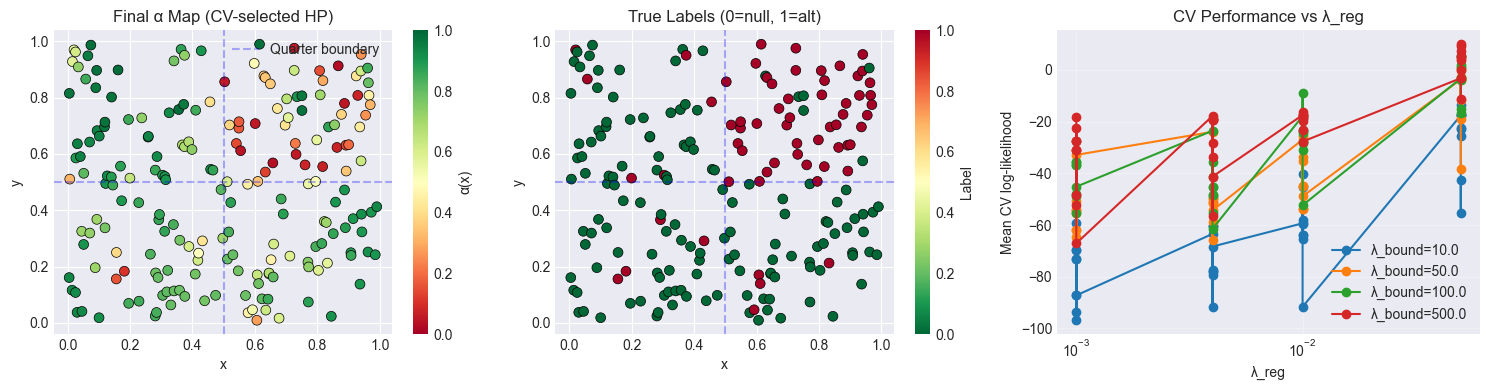


✅ CV-based hyperparameter tuning complete!


In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Learned α map
scatter1 = axes[0].scatter(locations[:, 0], locations[:, 1], 
                          c=alpha_final, cmap='RdYlGn', s=50,
                          vmin=0, vmax=1, edgecolors='black', linewidth=0.5)
axes[0].axvline(0.5, color='blue', linestyle='--', alpha=0.3, label='Quarter boundary')
axes[0].axhline(0.5, color='blue', linestyle='--', alpha=0.3)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Final α Map (CV-selected HP)')
axes[0].legend()
plt.colorbar(scatter1, ax=axes[0], label='α(x)')

# Plot 2: True labels
scatter2 = axes[1].scatter(locations[:, 0], locations[:, 1],
                          c=labels, cmap='RdYlGn_r', s=50,
                          vmin=0, vmax=1, edgecolors='black', linewidth=0.5)
axes[1].axvline(0.5, color='blue', linestyle='--', alpha=0.3)
axes[1].axhline(0.5, color='blue', linestyle='--', alpha=0.3)
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('True Labels (0=null, 1=alt)')
plt.colorbar(scatter2, ax=axes[1], label='Label')

# Plot 3: CV scores by lambda_reg
for lb in hp_grid['lambda_bound']:
    subset = df[df['lambda_bound'] == lb]
    axes[2].plot(subset['lambda_reg'], subset['mean_cv_loglik'], 
                marker='o', label=f'λ_bound={lb}')
axes[2].set_xlabel('λ_reg')
axes[2].set_ylabel('Mean CV log-likelihood')
axes[2].set_xscale('log')
axes[2].set_title('CV Performance vs λ_reg')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ CV-based hyperparameter tuning complete!")